### Series temporales: ARIMAX

In [78]:
# Importamos librerías a usar
import warnings
warnings.simplefilter('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from datetime import datetime


#### 1. Predicción precio ventas

En esta primera predicción, trataremos de predecir el precio del m2 en Madrid del próximo mes en base al histórico de precio por m2, renta media de madrid y valor del euribor.

- Lo primero, vamos a leer nuestros csv: 
    - Mensualmente, los precios del m2 en venta en la ciudad de madrid. Este será el dato que queremos predecir. Por otro lado, nuestros valores exógenos serán la renta media y la variación del euribor porque, tras el análisis exploratorio, consideramos que son las variables que más pueden influenciar.

In [79]:
df_ventas = pd.read_csv('tablas/ventas_01_23.csv')
df_euribor = pd.read_csv('tablas/euribor_94_23.csv')
df_renta = pd.read_csv('tablas/renta_02_22.csv')

- Ahora crearemos nuestro dataframe completo, con los valores unidos del resto de dataframes renombrando las columnas para hacerlas identificables y creando una columna 'date'

In [80]:
#Lo primero, seleccionados solo madrid, solo el precio de venta y la fecha y lo convertimos a año y mes
condicion = df_ventas['distrito'] == 'madrid'
df_ventas_ag = df_ventas[condicion]
df_ventas_ag2=df_ventas_ag[['date', 'precio_m2']]
df_ventas_ag2.rename(columns={'precio_m2':'precio_m2_venta'}, inplace=True)
df_ventas_ag2['date'] = pd.to_datetime(df_ventas_ag2['date']).dt.to_period('M')

condicion2 = df_renta['distrito'] == 'madrid'
df_renta_ag = df_renta[condicion2]
df_renta_ag2 = df_renta_ag[['date', 'valor']]
df_renta_ag2.rename(columns={'valor':'renta_media'}, inplace=True)
df_renta_ag2['date'] = pd.to_datetime(df_renta_ag2['date']).dt.to_period('M')

#Después seleccionamos date y el valor del euribor y realizamos las mismas operaciones
df_euribor2 = df_euribor[['date', 'valor']]
df_euribor2['date'] = pd.to_datetime(df_euribor2['date']).dt.to_period('M')
df_euribor2.rename(columns={'valor':'euribor'}, inplace=True)

#Por último, hacemos un inner joins por las fechas
df_completo = df_ventas_ag2.merge(df_euribor2, on='date', how='inner')
df_completo = df_completo.merge(df_renta_ag2, on='date', how='left')
df_completo.head(12)

,date,precio_m2_venta,euribor,renta_media
0,2023-06,4015,4.0073,NaN
1,2023-05,3979,3.8618,NaN
2,2023-04,3977,3.7437,NaN
3,2023-03,3935,3.6466,NaN
4,2023-02,3900,3.5336,NaN
5,2023-01,3870,3.3370,24797.0
6,2022-12,3881,3.0181,NaN
7,2022-11,3916,2.8283,NaN
8,2022-10,3916,2.6294,NaN
9,2022-09,3912,2.2330,NaN


- Como vemos, solo tenemos datos de renta media por año y nos rellena con NaNs los valores de los meses intermedios. Vamos a solucionarlo con un interpolate.

In [81]:
df_completo['renta_media'].interpolate(method='linear', inplace=True, limit_direction='both')

# Redondear los valores resultantes a enteros
df_completo['renta_media'] = df_completo['renta_media'].round().astype(int)
df_completo.head(12)

,date,precio_m2_venta,euribor,renta_media
0,2023-06,4015,4.0073,24797
1,2023-05,3979,3.8618,24797
2,2023-04,3977,3.7437,24797
3,2023-03,3935,3.6466,24797
4,2023-02,3900,3.5336,24797
5,2023-01,3870,3.3370,24797
6,2022-12,3881,3.0181,24764
7,2022-11,3916,2.8283,24732
8,2022-10,3916,2.6294,24699
9,2022-09,3912,2.2330,24666


- Ahora vamos a hacer la prueba de un modelo ARIMAX. ARIMAX es un acrónimo de "AutoRegressive Integrated Moving Average":

    - AutoRegressive (AR): Es decir, que el valor actual de la serie de datos depende de sus valores anteriores. Lo que ha pasado antes influye en el presente.

    - Integrated (I): 'Integrada' implica que se realiza una diferencia entre los datos observados y los anteriores para hacer que la serie sea más estacionaria, es decir, que sus propiedades estadísticas no cambian con el tiempo para facilitar la predicción.

    - Moving Average (MA): 'Media móvil. Es decir, calcular la media de un conjunto de valores de forma consecutiva, para suavizar los datos y eliminar el ruido o la aleatoriedad, que permite detectar mejor las tendencias. 

    -Componente Exógeno (X): Incorporando variables exógenas podemos capturar relaciones con factores externos que pueden afectar a la serie temporal.

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

Comenzamos :
- Convertimos la columna 'date' a datetime con timestamp, un modelo de representación de marca de tiempo en milisegundos que permite cálculos más avanzados.
- Luego convertimos 'date' en el índice, lo que es útil para trabajar con series temporales.
- Por último ordenamos el index de forma cronológica.

In [82]:
df_completo['date'] = pd.to_datetime(df_completo['date'].dt.to_timestamp())
df_completo = df_completo.set_index('date')
df_completo = df_completo.sort_index()

Continuamos:
- Vamos a crear una variable llamada 'serie_temporal', extrayendo la columna 'precio_m2', que será nuestro objetivo. Nuestra Y, si queremos llamarla así. Es sobre la que aplicaremos el modelo ARIMAX para realizar las predicciones.

Ahora, aunque vamos a trabajar con fechas que ya conocemos, queremos ser capaces de intentar predecir un mes o meses para los que aún no tenemos datos. Para ello haremos lo siguiente:

- Con un .reindex (método que podemos usar para incorporar o cambiar los valores del index) y un date_range, vamos a añadir 3 filas más, correspondientes a los meses de julio, agosto y septiembre -07, 08, 09-. Estas filas van a rellenar sus columnas (en este caso, su única columna, precio_m2) con NaNs en caso de que no haya valores que le correspondan. 
- Por último, vamos a usar una interpolación para rellenar esos NaNs con sus valores intermedios. en este caso, el valor intermedio no existe ya que no tenemos el valor del precio_m2 de octubre para poder rellenar, así que lo que hará será rellenar con el último valor conocido.

In [83]:
serie_temporal = df_completo['precio_m2_venta']
extended_serie_temporal = serie_temporal.reindex(serie_temporal.index.union(pd.date_range('2023-07-01', '2023-09-01', freq='MS')))
extended_serie_temporal.interpolate(method='linear', inplace=True)
extended_serie_temporal

2001-01-01    1542.0
2001-02-01    1542.0
2001-03-01    1542.0
2001-04-01    1592.0
2001-05-01    1592.0
               ...  
2023-05-01    3979.0
2023-06-01    4015.0
2023-07-01    4015.0
2023-08-01    4015.0
2023-09-01    4015.0
Freq: MS, Name: precio_m2_venta, Length: 273, dtype: float64

- Ahora crearemos las dos variables exógenas, el euribor y la renta media.
- Incorporaremos de nuevo estas nuevas filas de fecha para los meses que aún no tenemos.

In [84]:
euribor = df_completo['euribor']
extended_euribor = euribor.reindex(serie_temporal.index.union(pd.date_range('2023-07-01', '2023-09-01', freq='MS')))
extended_euribor.interpolate(method='linear', inplace=True)

In [85]:
renta = df_completo['renta_media']
extended_renta = renta.reindex(serie_temporal.index.union(pd.date_range('2023-07-01', '2023-09-01', freq='MS')))
extended_renta.interpolate(method='linear', inplace=True)

Ahora:
- Dividimos en train y test, dándole al train los datos hasta mayo de 2023, y dejando como objetivo junio de 2023. Lo entrenaremos con datos históricos para luego evaluar su rendimiento al predecir junio. Creamos también una variable exog_test, para tener los valores del euribor y la renta en junio e intentar predecir el valor en junio.
- Incluimos una variable exógena con los exog_values del euribor y del alquiler para transformar nuestro ARIMA a ARIMAX
- A continuación entrenamos el modelo ARIMA con los parámetros 'order' (1,0,0) que significa que tiene una parte auto-regresiva de orden 1 (es decir, que vamos a usar una regresión lineal teniendo en cuenta el valor inmediatamente anterior para hacer las predicciones), una integrada de orden 0 (no realiza diferenciaciones para hacer la serie estacionarios) y una parte de media móvil de orden 0 (No la hace). Tras muchos ensayos, es el que más nos convence. Incluímos los exog_values
- Hacemos un fit para ajustarlo al conjunto de datos de entrenamiento.

In [86]:

train_start = '2008-01'
train_end = '2023-05'
objetivo = '2023-06'
train = extended_serie_temporal[train_start:train_end]
test = extended_serie_temporal[objetivo]

exog_values = pd.concat([extended_euribor[train_start:train_end], extended_renta[train_start:train_end]], axis=1)
exog_test = pd.concat([extended_euribor[objetivo], extended_renta[objetivo]], axis=1).values

model = sm.tsa.ARIMA(train, order=(1, 0, 0), exog=exog_values)
model_fit = model.fit()


- Realizaremos la predicción para junio de 2023 con un único salto de mes (la len() del 'test'), y los valores exógenos de ese mes.

- Acto seguido, vamos a crear un datetime de nuestra fecha objetivo (en este caso '2023-06'), para de ahi sacar el nombre del mes y el del año e imprimir la predicción junto con el valor del forecast.

In [87]:
forecast = model_fit.forecast(steps=len(test), exog=exog_test)


fecha = datetime.strptime(objetivo, '%Y-%m')
nombre_mes = fecha.strftime('%B')
anio = fecha.year

cadena_final = f'{nombre_mes} de {anio}'
print(f"Predicción para {cadena_final}:")
print(forecast.iloc[0].round(1))  # Simplemente imprime el valor directamente


Predicción para June de 2023:
3985.9


- Ahora, crearemos un plot con la predicción del precio de venta por metro cuadrado, representando previamente la línea del precio real de venta por m2.

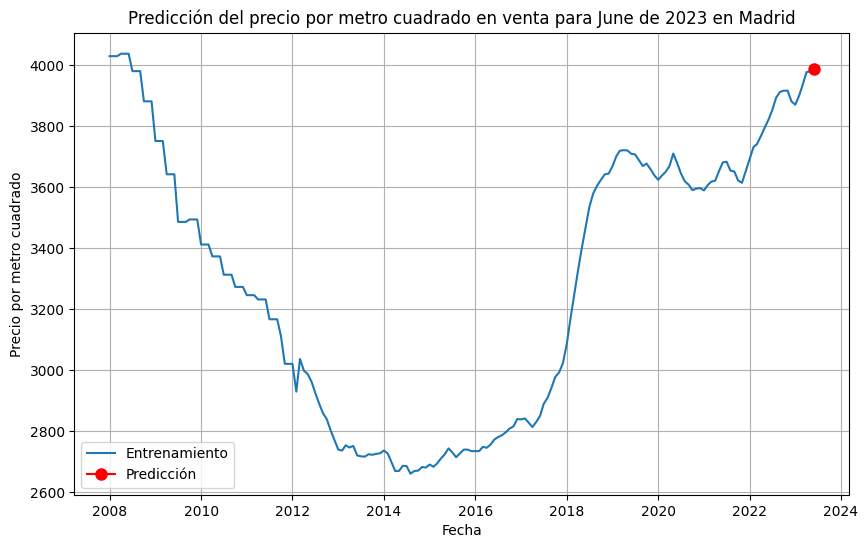

In [88]:

plt.figure(figsize=(10, 6))
plt.plot(train, label='Entrenamiento')
plt.plot(test.index[-1], forecast, marker='o', markersize=8, label='Predicción', color='red')  # Graficar solo el valor para septiembre de 2023
plt.xlabel('Fecha')
plt.ylabel('Precio por metro cuadrado')
plt.title(f'Predicción del precio por metro cuadrado en venta para {cadena_final} en Madrid')
plt.legend()
plt.grid(True)
plt.show()

- Por último, vamos a comprobar la relación entre valor real y predicho:
    - Extraemos el valor real de los valores de test, escogiendo el único valor del test para que salga en formato float
    - Extraemos también la única fila del forecast con un .iloc.

- Calculamos el error cuadrático medio y el error absoluto medio.
- Calculamos la desviación estándar mes a mes para el precio de venta, sacando un dataframe con las diferencias de precio con respecto al mes previo y realizando un .std()

Estos datos nos permitirán comprobar cuánto se acerca nuestra predicción al número real y si está por debajo de la desviación estándar. Redondearemos todos para facilitar la legibilidad.

In [ ]:
y_true_june = test.values[-1].round(2)
forecast_june = forecast.iloc[0].round(2)


mse = mean_squared_error([y_true_june], [forecast_june]).round(2)


mae = mean_absolute_error([y_true_june], [forecast_june]).round(2)


diff_precios_m2 = train.diff()
desviacion_estandar_fila_a_fila = diff_precios_m2.std().round(2)



print(f"Valor real de {cadena_final}:", y_true_june)
print(f"Valor predicho para {cadena_final}:", forecast_june)
print(f"Error Cuadrático Medio (MSE) para {cadena_final}:", mse)
print(f"Error Absoluto Medio (MAE) para {cadena_final}:", mae)
print("Desviación estándar de mes a mes en el precio por metro cuadrado en el rango de fechas:", desviacion_estandar_fila_a_fila)

Valor real de June de 2023: 4015.0
Valor predicho para June de 2023: 3985.94
Error Cuadrático Medio (MSE) para June de 2023: 844.48
Error Absoluto Medio (MAE) para June de 2023: 29.06
Desviación estándar de mes a mes en el precio por metro cuadrado en el rango de fechas: 33.85


El Error Absoluto Medio indica la discrepancia promedio entre los valores reales y los valores predichos en un modelo. Al calcular la desviación estándar de las diferencias entre filas consecutivas, estamos evaluando cuánto varían los cambios en la serie temporal.

Si el MAE se mantiene consistentemente por debajo de la desviación estándar, tendremos un buen modelo. Esto indica que las predicciones se encuentran en general más cerca de los valores reales y que la discrepancia entre ellos es menor.

------------------------------------------------------------------------------
Para terminar de evaluar nuestro modelo, calcularemos el error absoluto y desviación estándar de los últimos 12 meses, cambiando el rango de fecha. Si está consistentemente por debajo de la desviación estándar, será un modelo fiable.

In [ ]:
import pandas as pd
import statsmodels.api as sm
from datetime import datetime
from sklearn.metrics import mean_absolute_error

train_start = '2008-01'
current_end = '2023-05'
current_objetivo = '2023-06'
mae_list = []
std_dev_list = []

while current_end >= '2022-05':
    train = extended_serie_temporal[train_start:current_end]
    test = extended_serie_temporal[current_objetivo]
    exog_test = pd.concat([extended_euribor[current_objetivo], extended_renta[current_objetivo]], axis=1).values
    exog_values = pd.concat([extended_euribor[train_start:current_end], extended_renta[train_start:current_end]], axis=1)
    
    model = sm.tsa.ARIMA(train, order=(1, 0, 0), exog=exog_values)
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=len(test), exog=exog_test)
    
    fecha = datetime.strptime(current_objetivo, '%Y-%m')
    nombre_mes = fecha.strftime('%B')
    anio = fecha.year
    cadena_final = f'{nombre_mes} de {anio}'
    
    y_true = test.values[-1].round(2)
    forecast_june = forecast.iloc[0].round(2)
    mae = mean_absolute_error([y_true], [forecast_june]).round(2)
    diff_precios_m2 = train.diff()
    desviacion_estandar_fila_a_fila = diff_precios_m2.std().round(2)
    
    mae_list.append(mae)
    std_dev_list.append(desviacion_estandar_fila_a_fila)
    
    print(f"Valor real de {cadena_final}: {y_true}")
    print(f"Valor predicho para {cadena_final}: {forecast_june}")
    print(f"Error Absoluto Medio (MAE) para {cadena_final}: {mae}")
    print("Desviación estándar de mes a mes en el precio por metro cuadrado en el rango de fechas:", desviacion_estandar_fila_a_fila)
    print("\n")
    
    # Actualizar los valores para la siguiente iteración
    current_end = (datetime.strptime(current_end, '%Y-%m') - pd.DateOffset(months=1)).strftime('%Y-%m')
    current_objetivo = (datetime.strptime(current_objetivo, '%Y-%m') - pd.DateOffset(months=1)).strftime('%Y-%m')

mae_mean = (sum(mae_list) / len(mae_list)).round(2)
std_dev_mean = (sum(std_dev_list) / len(std_dev_list)).round(2)
print(f"Media de los MAEs: {mae_mean}")
print(f"Media de la desviación estándar mes a mes en el precio por metro cuadrado en el rango de fechas: {std_dev_mean}")


Valor real de June de 2023: 4015.0
Valor predicho para June de 2023: 3985.94
Error Absoluto Medio (MAE) para June de 2023: 29.06
Desviación estándar de mes a mes en el precio por metro cuadrado en el rango de fechas: 33.85


Valor real de May de 2023: 3979.0
Valor predicho para May de 2023: 3982.75
Error Absoluto Medio (MAE) para May de 2023: 3.75
Desviación estándar de mes a mes en el precio por metro cuadrado en el rango de fechas: 33.94


Valor real de April de 2023: 3977.0
Valor predicho para April de 2023: 3939.76
Error Absoluto Medio (MAE) para April de 2023: 37.24
Desviación estándar de mes a mes en el precio por metro cuadrado en el rango de fechas: 33.89


Valor real de March de 2023: 3935.0
Valor predicho para March de 2023: 3903.6
Error Absoluto Medio (MAE) para March de 2023: 31.4
Desviación estándar de mes a mes en el precio por metro cuadrado en el rango de fechas: 33.88


Valor real de February de 2023: 3900.0
Valor predicho para February de 2023: 3878.46
Error Absoluto 

- Comprobamos que, efectivamente, la media de los MAEs de las predicciones de los últimos 12 meses es menor a la desviación estándar mes a mes del rango de fechas sometidos a estudio. 
- Concluimos que es un modelo que puede predecir, de forma más fiable que la pura estadística, el precio del próximo mes.

#### 2. Predicción precio alquiler

- Teniendo ya un modelo exitoso, vamos a probar a predecir el precio del alquiler, esta vez teniendo en cuenta como variables exógenas la renta y el precio medio de venta por m2.

In [ ]:
df_alquiler = pd.read_csv('tablas/alquiler_12_23.csv')
df_venta = pd.read_csv('tablas/ventas_01_23.csv')
df_renta = pd.read_csv('tablas/renta_02_22.csv')

In [ ]:
#Lo primero, seleccionados solo madrid, solo el precio de venta y la fecha y lo convertimos a año y mes
condicion = df_alquiler['distrito'] == 'madrid'
df_alquiler_ag = df_alquiler[condicion]
df_alquiler_ag2=df_alquiler_ag[['date', 'precio_m2']]
df_alquiler_ag2.rename(columns={'precio_m2':'precio_m2_alquiler'}, inplace=True)
df_alquiler_ag2['date'] = pd.to_datetime(df_alquiler_ag2['date']).dt.to_period('M')

condicion2 = df_renta['distrito'] == 'madrid'
df_renta_ag = df_renta[condicion2]
df_renta_ag2 = df_renta_ag[['date', 'valor']]
df_renta_ag2.rename(columns={'valor':'renta_media'}, inplace=True)
df_renta_ag2['date'] = pd.to_datetime(df_renta_ag2['date']).dt.to_period('M')

#Después seleccionamos date y el valor del euribor y realizamos las mismas operaciones
condicion3 = df_venta['distrito'] == 'madrid'
df_venta = df_venta[condicion3]
df_venta2 = df_venta[['date', 'precio_m2']]
df_venta2['date'] = pd.to_datetime(df_venta2['date']).dt.to_period('M')
df_venta2.rename(columns={'precio_m2':'precio_m2_venta'}, inplace=True)

#Por último, hacemos un inner joins por las fechas
df_completo = df_alquiler_ag2.merge(df_venta2, on='date', how='inner')
df_completo = df_completo.merge(df_renta_ag2, on='date', how='left')
df_completo['renta_media'].interpolate(method='linear', inplace=True, limit_direction='both')

# Redondear los valores resultantes a enteros
df_completo['renta_media'] = df_completo['renta_media'].round().astype(int)

In [ ]:
df_completo['date'] = pd.to_datetime(df_completo['date'].dt.to_timestamp())
df_completo = df_completo.set_index('date')
df_completo = df_completo.sort_index()

In [ ]:
serie_temporal = df_completo['precio_m2_alquiler']
extended_serie_temporal = serie_temporal.reindex(serie_temporal.index.union(pd.date_range('2023-07-01', '2023-09-01', freq='MS')))
extended_serie_temporal.interpolate(method='linear', inplace=True)
extended_serie_temporal

2012-03-01    12.0
2012-04-01    11.9
2012-05-01    11.9
2012-06-01    11.9
2012-07-01    11.8
              ... 
2023-05-01    16.6
2023-06-01    16.8
2023-07-01    16.8
2023-08-01    16.8
2023-09-01    16.8
Freq: MS, Name: precio_m2_alquiler, Length: 139, dtype: float64

In [ ]:
venta_exog = df_completo['precio_m2_venta']
extended_venta = venta_exog.reindex(serie_temporal.index.union(pd.date_range('2023-07-01', '2023-09-01', freq='MS')))
extended_venta.interpolate(method='linear', inplace=True)

In [ ]:
renta_exog = df_completo['renta_media']
extended_renta = renta_exog.reindex(serie_temporal.index.union(pd.date_range('2023-07-01', '2023-09-01', freq='MS')))
extended_renta.interpolate(method='linear', inplace=True)

In [ ]:

train_start = '2008-01'
train_end = '2023-05'
objetivo = '2023-06'
train = extended_serie_temporal[train_start:train_end]
test = extended_serie_temporal[objetivo]
exog_test = pd.concat([extended_venta[objetivo], extended_renta[objetivo]], axis=1).values

exog_values = pd.concat([extended_venta[train_start:train_end], extended_renta[train_start:train_end]], axis=1)

model = sm.tsa.ARIMA(train, order=(1, 1, 0), exog=exog_values)
model_fit = model.fit()


In [ ]:
forecast = model_fit.forecast(steps=len(test), exog=exog_test)


fecha = datetime.strptime(objetivo, '%Y-%m')
nombre_mes = fecha.strftime('%B')
anio = fecha.year

cadena_final = f'{nombre_mes} de {anio}'
print(f"Predicción para {cadena_final}:")
print(forecast.iloc[0].round(1))  # Simplemente imprime el valor directamente


Predicción para June de 2023:
16.8


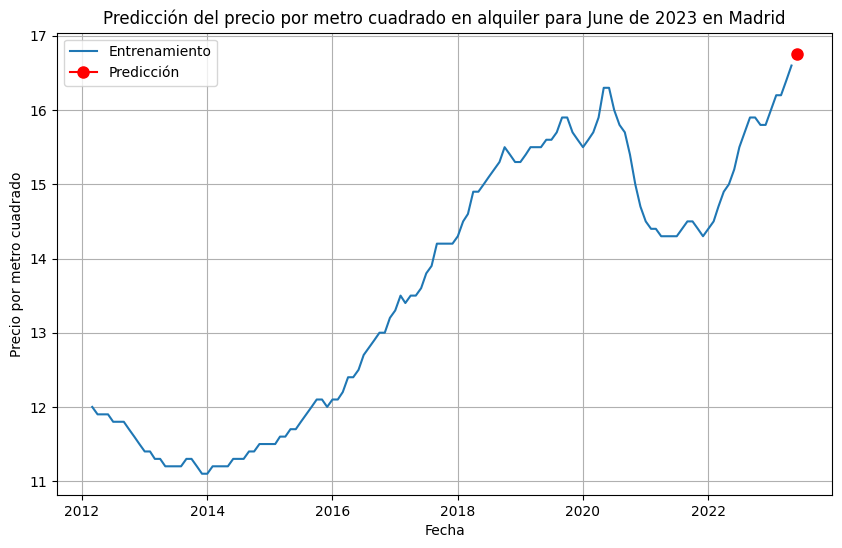

In [ ]:

plt.figure(figsize=(10, 6))
plt.plot(train, label='Entrenamiento')
plt.plot(test.index[-1], forecast, marker='o', markersize=8, label='Predicción', color='red')  # Graficar solo el valor para septiembre de 2023
plt.xlabel('Fecha')
plt.ylabel('Precio por metro cuadrado')
plt.title(f'Predicción del precio por metro cuadrado en alquiler para {cadena_final} en Madrid')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
y_true_june = test.values[-1].round(2)
forecast_june = forecast.iloc[0].round(2)


mse = mean_squared_error([y_true_june], [forecast_june]).round(2)


mae = mean_absolute_error([y_true_june], [forecast_june]).round(2)


diff_precios_m2 = train.diff()
desviacion_estandar_fila_a_fila = diff_precios_m2.std().round(2)



print(f"Valor real de {cadena_final}:", y_true_june)
print(f"Valor predicho para {cadena_final}:", forecast_june)
print(f"Error Cuadrático Medio (MSE) para {cadena_final}:", mse)
print(f"Error Absoluto Medio (MAE) para {cadena_final}:", mae)
print("Desviación estándar de mes a mes en el precio por metro cuadrado en el rango de fechas:", desviacion_estandar_fila_a_fila)

Valor real de June de 2023: 16.8
Valor predicho para June de 2023: 16.76
Error Cuadrático Medio (MSE) para June de 2023: 0.0
Error Absoluto Medio (MAE) para June de 2023: 0.04
Desviación estándar de mes a mes en el precio por metro cuadrado en el rango de fechas: 0.13


In [ ]:
import pandas as pd
import statsmodels.api as sm
from datetime import datetime
from sklearn.metrics import mean_absolute_error

train_start = '2008-01'
current_end = '2023-05'
current_objetivo = '2023-06'
mae_list = []
std_dev_list = []

while current_end >= '2022-05':
    train = extended_serie_temporal[train_start:current_end]
    test = extended_serie_temporal[current_objetivo]
    exog_test = pd.concat([extended_venta[current_objetivo], extended_renta[current_objetivo]], axis=1).values
    exog_values = pd.concat([extended_venta[train_start:current_end], extended_renta[train_start:current_end]], axis=1)
    
    model = sm.tsa.ARIMA(train, order=(1, 1, 1), exog=exog_values)
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=len(test), exog=exog_test)
    
    fecha = datetime.strptime(current_objetivo, '%Y-%m')
    nombre_mes = fecha.strftime('%B')
    anio = fecha.year
    cadena_final = f'{nombre_mes} de {anio}'
    
    y_true = test.values[-1].round(2)
    forecast_june = forecast.iloc[0].round(2)
    mae = mean_absolute_error([y_true], [forecast_june]).round(2)
    diff_precios_m2 = train.diff()
    desviacion_estandar_fila_a_fila = diff_precios_m2.std().round(2)
    
    mae_list.append(mae)
    std_dev_list.append(desviacion_estandar_fila_a_fila)
    
    print(f"Valor real de {cadena_final}: {y_true}")
    print(f"Valor predicho para {cadena_final}: {forecast_june}")
    print(f"Error Absoluto Medio (MAE) para {cadena_final}: {mae}")
    print("Desviación estándar de mes a mes en el precio por metro cuadrado en el rango de fechas:", desviacion_estandar_fila_a_fila)
    print("\n")
    
    current_end = (datetime.strptime(current_end, '%Y-%m') - pd.DateOffset(months=1)).strftime('%Y-%m')
    current_objetivo = (datetime.strptime(current_objetivo, '%Y-%m') - pd.DateOffset(months=1)).strftime('%Y-%m')


mae_mean = (sum(mae_list) / len(mae_list)).round(2)
std_dev_mean = (sum(std_dev_list) / len(std_dev_list)).round(2)
print(f"Media de los MAEs: {mae_mean}")
print(f"Media de la desviación estándar mes a mes en el precio por metro cuadrado en el rango de fechas: {std_dev_mean}")


Valor real de June de 2023: 16.8
Valor predicho para June de 2023: 16.76
Error Absoluto Medio (MAE) para June de 2023: 0.04
Desviación estándar de mes a mes en el precio por metro cuadrado en el rango de fechas: 0.13


Valor real de May de 2023: 16.6
Valor predicho para May de 2023: 16.45
Error Absoluto Medio (MAE) para May de 2023: 0.15
Desviación estándar de mes a mes en el precio por metro cuadrado en el rango de fechas: 0.13


Valor real de April de 2023: 16.4
Valor predicho para April de 2023: 16.26
Error Absoluto Medio (MAE) para April de 2023: 0.14
Desviación estándar de mes a mes en el precio por metro cuadrado en el rango de fechas: 0.13


Valor real de March de 2023: 16.2
Valor predicho para March de 2023: 16.34
Error Absoluto Medio (MAE) para March de 2023: 0.14
Desviación estándar de mes a mes en el precio por metro cuadrado en el rango de fechas: 0.13


Valor real de February de 2023: 16.2
Valor predicho para February de 2023: 16.15
Error Absoluto Medio (MAE) para February

- En este caso, el modelo es 2 centimos más bajo que la desviación estándar, lo que sigue siendo un resultado bastante aceptable.